In [115]:
# making the cramer rao lower bound plots
# essentially, how well you can constrain the position of something is given by how much its gradient changes
# first, we need to generate airy disc and toliman psfs. 

# but before that, get our imports done
import dLux as dl
import dLuxToliman as dlT
# gonna use normal numpy. jax numpy is weird.
import numpy as np
from matplotlib import pyplot as plt
import dLux.utils as dlu
import jax
import jax.random as jr

In [144]:
# let's create the toliman pupil and obstructions, call it tolOptics

# might as well use 1024 pixels wavefront. nice and large number
wf_npixels = 1024

# same for psf
psf_npixels = 128

# no need for oversampling
oversample = 1

# toliman pixel scale
psf_pixel_scale = 0.375

tolOptics = dlT.TolimanOpticalSystem(wf_npixels, psf_npixels, oversample, psf_pixel_scale)

In [145]:
# now let's extract the pupil
tolPupil = tolOptics.pupil.opd

# make it a nice phase difference instead of OPD
tolPupilPhase = dlu.opd2phase(tolPupil, 585e-9) # it is pi phase difference for 585e-9 wavelength

# layer
tolPupilLayer = dl.layers.AberratedLayer(phase=tolPupilPhase)

# (normal toliman diameter)
diameter = 0.125

# initialsing coords for circular aperture
coords = dlu.pixel_coords(wf_npixels,diameter)

# x = np.arange(wf_npixels)
# y = np.arange(wf_npixels)
# X, Y = np.meshgrid(x,y, indexing = 'ij') # I believe the indexing part is neccessary? Anyway doesn't break anything

# creating the aperture (circular)
airyAperture = dlu.circle(coords,0.5 * diameter)

# making it a layer
airyApertureLayer = dl.layers.TransmissiveLayer(transmission=airyAperture, normalise=True)

In [146]:
# making the optical systems
tolPupilLayers = [
    (
        'aperture',
        airyApertureLayer
    ),
    (
        'pupil',
        tolPupilLayer
    )
]

airyApertureLayers = [
    (
        'aperture',
        airyApertureLayer
    )
]

tolPupilSystem = dl.AngularOpticalSystem(wf_npixels, diameter, tolPupilLayers, psf_npixels, psf_pixel_scale, oversample)

airyApertureSystem = dl.AngularOpticalSystem(wf_npixels, diameter, airyApertureLayers, psf_npixels, psf_pixel_scale, oversample)

In [287]:
# making the initial source

# just monochromatic
wavelengths = np.linspace(585e-9,585e-9,1)
# monochromatic
weights = np.linspace(1,1,1)

# at 0,0
position = np.array([0.000001,0])
# position = np.array([0.00001,0])

# many photons
flux = fluxes[5] #1 million photons

# source
source = dl.PointSource(wavelengths, position, flux, weights)

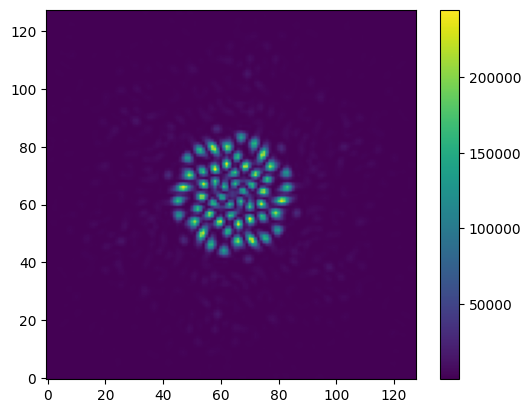

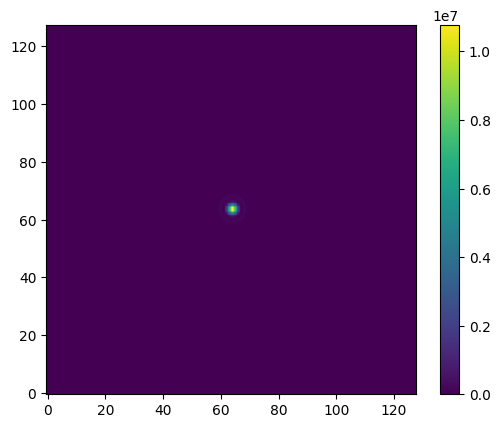

In [288]:
# getting the psfs!
airyPsf = airyApertureSystem.model(source)

tolPsf = tolPupilSystem.model(source)

plt.imshow(tolPsf,origin='lower')
plt.colorbar()
plt.show()
plt.imshow(airyPsf,origin='lower')
plt.colorbar()
plt.show()

In [149]:
# need to now make functions calculating the gradient
# do we need pixel scale?

# initialising derivative array
airyPsfDx = np.zeros_like(airyPsf)

# first column (forward difference)
airyPsfDx[:, 0] = airyPsf[:, 1] - airyPsf[:, 0]

# middle columns (middle difference)
airyPsfDx[:, 1:-1] = (airyPsf[:, 2:] - airyPsf[:, :-2])/2

# final column (backwards difference)
airyPsfDx[:, -1] = airyPsf[:, -1] - airyPsf[:, -2]

# now for toliman
# initialising derivative array
tolPsfDx = np.zeros_like(tolPsf)

# first column (forward difference)
tolPsfDx[:, 0] = tolPsf[:, 1] - tolPsf[:, 0]

# middle columns (middle difference)
tolPsfDx[:, 1:-1] = (tolPsf[:, 2:] - tolPsf[:, :-2])/2

# final column (backwards difference)
tolPsfDx[:, -1] = tolPsf[:, -1] - tolPsf[:, -2]

In [150]:
airyInverseDiffSquare = np.sum(airyPsfDx**2/airyPsf)
tolInverseDiffSquare = np.sum(tolPsfDx**2/tolPsf)

In [151]:
# arcseconds!
print(psf_pixel_scale*1/np.sqrt(airyInverseDiffSquare))
print(psf_pixel_scale*1/np.sqrt(tolInverseDiffSquare))

0.0026219832
0.00443022


In [277]:
# now... generate a lot of them for many photon counts and get some numbers
fluxes = np.logspace(3,9,7)

# just monochromatic
wavelengths = np.linspace(585e-9,585e-9,1)
# monochromatic
weights = np.linspace(1,1,1)

# at 0,0
position = dlu.arcsec2rad(np.array([0,0]))

airyCramer = np.zeros_like(fluxes)
tolCramer = np.zeros_like(fluxes)

# for photon noise
total_samples = 20

# setting up noise psfs
airyPsfNoise = np.zeros((fluxes.shape[0], total_samples, psf_npixels, psf_npixels))
tolPsfNoise = np.zeros((fluxes.shape[0], total_samples, psf_npixels, psf_npixels))

# many photons
for i, flux in enumerate(fluxes):
    # source
    source = dl.PointSource(wavelengths, position, flux, weights)
    airyPsf = airyApertureSystem.model(source)

    tolPsf = tolPupilSystem.model(source)

    # need to now make functions calculating the gradient
    # do we need pixel scale?

    # initialising derivative array
    airyPsfDx = np.zeros_like(airyPsf)

    # first column (forward difference)
    airyPsfDx[:, 0] = airyPsf[:, 1] - airyPsf[:, 0]

    # middle columns (middle difference)
    airyPsfDx[:, 1:-1] = (airyPsf[:, 2:] - airyPsf[:, :-2])/2

    # final column (backwards difference)
    airyPsfDx[:, -1] = airyPsf[:, -1] - airyPsf[:, -2]

    # now for toliman
    # initialising derivative array
    tolPsfDx = np.zeros_like(tolPsf)

    # first column (forward difference)
    tolPsfDx[:, 0] = tolPsf[:, 1] - tolPsf[:, 0]

    # middle columns (middle difference)
    tolPsfDx[:, 1:-1] = (tolPsf[:, 2:] - tolPsf[:, :-2])/2

    # final column (backwards difference)
    tolPsfDx[:, -1] = tolPsf[:, -1] - tolPsf[:, -2]

    airyInverseDiffSquare = np.sum(airyPsfDx**2/airyPsf)
    tolInverseDiffSquare = np.sum(tolPsfDx**2/tolPsf)

    airyCramer[i] = psf_pixel_scale*1/np.sqrt(airyInverseDiffSquare)
    tolCramer[i] = psf_pixel_scale*1/np.sqrt(tolInverseDiffSquare)

    # now let's do it for some random samples from poisson distribution
    
    samples = np.arange(0,total_samples,1)

    for sample in samples:

        airyPsfNoise[i, sample] = jr.poisson(jr.PRNGKey(sample+1),airyPsf)
        tolPsfNoise[i, sample] = jr.poisson(jr.PRNGKey(sample+1),tolPsf)

        # below is calculating cramer rao. we don't need to do that and it doesnt make sense for noisy.
        # # initialising derivative array
        # airyPsfNoiseDx = np.zeros_like(airyPsfNoise)

        # # first column (forward difference)
        # airyPsfNoiseDx[:, 0] = airyPsfNoise[:, 1] - airyPsfNoise[:, 0]

        # # middle columns (middle difference)
        # airyPsfNoiseDx[:, 1:-1] = (airyPsfNoise[:, 2:] - airyPsfNoise[:, :-2])/2

        # # final column (backwards difference)
        # airyPsfNoiseDx[:, -1] = airyPsfNoise[:, -1] - airyPsfNoise[:, -2]

        # # now for toliman
        # # initialising derivative array
        # tolPsfNoiseDx = np.zeros_like(tolPsfNoise)

        # # first column (forward difference)
        # tolPsfNoiseDx[:, 0] = tolPsfNoise[:, 1] - tolPsfNoise[:, 0]

        # # middle columns (middle difference)
        # tolPsfNoiseDx[:, 1:-1] = (tolPsfNoise[:, 2:] - tolPsfNoise[:, :-2])/2

        # # final column (backwards difference)
        # tolPsfNoiseDx[:, -1] = tolPsfNoise[:, -1] - tolPsfNoise[:, -2]

        # # note: have to use acutal psf values so don't divide by zero ?
        # airyNoiseInverseDiffSquare = np.sum(airyPsfNoiseDx**2/airyPsf)
        # tolNoiseInverseDiffSquare = np.sum(tolPsfNoiseDx**2/tolPsf)

        # airyNoiseCramer[i,sample] = psf_pixel_scale*1/np.sqrt(airyNoiseInverseDiffSquare)
        # #print(airyNoiseCramer[i,sample])
        # tolNoiseCramer[i,sample] = psf_pixel_scale*1/np.sqrt(tolNoiseInverseDiffSquare)



    # rename the fluxes to the actual fluxes (number of photons on detector)
    



In [242]:
# now we want to infer the x-position (just 1 parameter), setting y-position to 0.
# first multithreaded stuff
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'
import numpyro as npy
import numpyro.distributions as dist
import jax.numpy as jnp

In [268]:
parameters = 'position'

def psf_model(data, model):
    """
    Define the numpyro function
    """
    position = jnp.array([npy.sample("position",        dist.Uniform(-1, 1)),0])
    

    with npy.plate("data", len(data.flatten())):

        poisson_model = dist.Poisson(
            model.set(parameters, dlu.arcsec2rad(position)).model().flatten(),
            )
        
        return npy.sample("psf", poisson_model, obs=data.flatten())

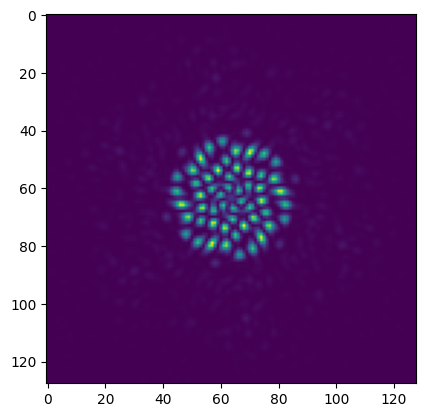

In [203]:
plt.imshow(tolPsfNoise[5,0])
plt.show()

In [269]:
# making the initial source

# just monochromatic
wavelengths = np.linspace(585e-9,585e-9,1)
# monochromatic
weights = np.linspace(1,1,1)

# at 0,0
position = dlu.arcsec2rad(np.array([0,0]))
# position = np.array([0.00001,0])

# many photons
flux = 1e4 #1 million photons
print(fluxes[5])
# source
source = dl.PointSource(wavelengths, position, fluxes[5], weights)

100000000.0


In [270]:
# define telescopes
airyTelescope = dl.Telescope(airyApertureSystem, ('source', source))
tolTelescope = dl.Telescope(tolPupilSystem, ('source', source))

from jax import device_count
sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model),    
    num_warmup=500,
    num_samples=500,
    num_chains=device_count(),
    progress_bar=True,
    
)
%time sampler.run(jr.PRNGKey(0), tolPsfNoise[5,0], tolTelescope)

sample: 100%|██████████| 1000/1000 [09:00<00:00,  1.85it/s, 3 steps of size 2.55e-06. acc. prob=0.86]    

CPU times: user 39min 43s, sys: 35.5 s, total: 40min 19s
Wall time: 9min


In [271]:
sampler.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  position     -0.67      0.00     -0.67     -0.67     -0.67      4.32      1.44

Number of divergences: 0


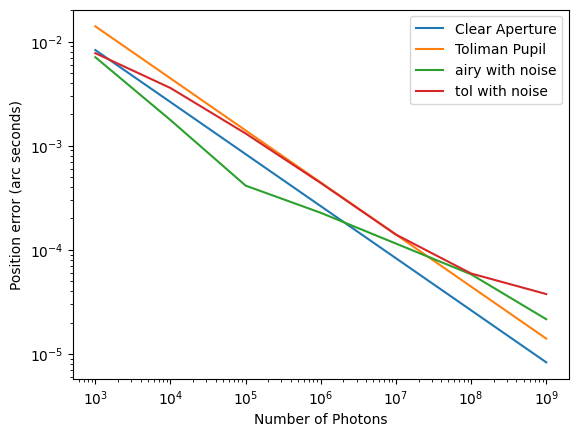

In [172]:
plt.loglog(fluxes,airyCramer,label='Clear Aperture')
plt.loglog(fluxes,tolCramer,label='Toliman Pupil')

plt.xlabel('Number of Photons')
plt.ylabel('Position error (arc seconds)')
plt.legend()
plt.show()

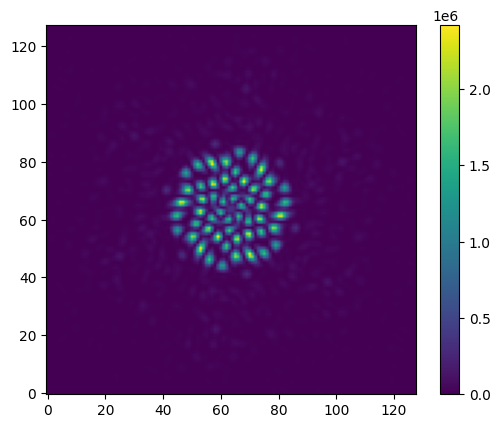

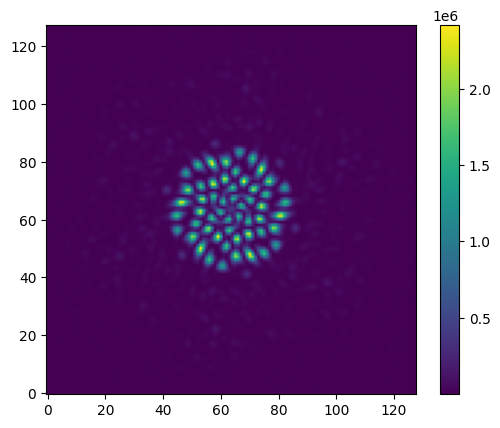

889993616
889964200.0


In [155]:
tolPsfNoise = jr.poisson(jr.PRNGKey(2), tolPsf)
plt.imshow(tolPsfNoise,origin='lower')
plt.colorbar()
plt.show()
plt.imshow(tolPsf,origin='lower')
plt.colorbar()
plt.show()
print(np.sum(tolPsfNoise))
print(np.sum(tolPsf))